In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_postulantes_edu = pd.read_csv('Desktop/Homework/datos_navent_fiuba/fiuba_1_postulantes_educacion.csv')
df_postulantes_datos = pd.read_csv('Desktop/Homework/datos_navent_fiuba/fiuba_2_postulantes_genero_y_edad.csv')
df_postulantes_vistas = pd.read_csv('Desktop/Homework/datos_navent_fiuba/fiuba_3_vistas.csv')
df_postulaciones = pd.read_csv('Desktop/Homework/datos_navent_fiuba/fiuba_4_postulaciones.csv')
df_avisos_online = pd.read_csv('Desktop/Homework/datos_navent_fiuba/fiuba_5_avisos_online.csv')
df_avisos_detalles = pd.read_csv('Desktop/Homework/datos_navent_fiuba/fiuba_6_avisos_detalle.csv')

In [3]:
df_postulaciones["fechapostulacion"] = pd.to_datetime(df_postulaciones["fechapostulacion"])
df_postulantes_vistas["timestamp"] = pd.to_datetime(df_postulantes_vistas["timestamp"])

# Top 5 empresas populares

Me quedo con la fecha mínima de cada aviso, tanto en postulaciones como vistas

In [4]:
fechas_postulaciones = df_postulaciones.loc[:, ['idaviso', 'fechapostulacion']].groupby('idaviso').min().reset_index()

In [5]:
fechas_vistas_postul = df_postulantes_vistas.rename(columns={'timestamp':'fechapostulacion', 'idAviso':'idaviso'})\
                        .loc[:, ['idaviso', 'fechapostulacion']].groupby('idaviso').min().reset_index()

Estas van a ser mis fechas iniciales (donde considero que empiezan los avisos)

In [6]:
fechas_iniciales = pd.concat([fechas_postulaciones, fechas_vistas_postul])#pd.merge(fechas_postulaciones, fechas_vistas_postul, on=['idaviso'], how='outer')

Me quedo con la menor de todas, sea vista o postulado efectivamente

In [7]:
fechas_iniciales = fechas_iniciales.groupby('idaviso').min().reset_index()

Lo agrego a los detalles de los avisos, por si me sirve

In [8]:
df_avisos_con_fecha = pd.merge(df_avisos_detalles, fechas_iniciales, on=['idaviso'], how='inner')

In [9]:
df_avisos_detalles.shape

(13534, 11)

Pierdo 1000 datos por meter la fecha inicial, en resumen, se pierden 1000 datos que no se vieron ni se postularon

In [10]:
df_avisos_con_fecha.shape

(12249, 12)

Hago lo mismo para obtener la fecha en que "finaliza" el aviso

In [11]:
fechas_postulaciones = df_postulaciones.loc[:, ['idaviso', 'fechapostulacion']].groupby('idaviso').max().reset_index()

In [12]:
fechas_vistas_postul = df_postulantes_vistas.rename(columns={'timestamp':'fechapostulacion', 'idAviso':'idaviso'})\
                        .loc[:, ['idaviso', 'fechapostulacion']].groupby('idaviso').max().reset_index()

In [13]:
fechas_finales = pd.concat([fechas_postulaciones, fechas_vistas_postul])

In [14]:
fechas_finales = fechas_finales.groupby('idaviso').max().reset_index()

In [15]:
fechas_finales.rename(columns={'fechapostulacion':'fecha_finpostulacion'}, inplace=True)

In [16]:
df_avisos_con_fecha = pd.merge(df_avisos_con_fecha, fechas_finales, on=['idaviso'], how='inner')

Por supuesto no pierdo nada porque estos avisos al menos ya se vieron/postularon en su fecha minima

In [17]:
df_avisos_con_fecha.shape

(12249, 13)

Agrego la cantidad de dias que "estuvo vigente" el aviso

In [18]:
def set_dias(row):
    return row.days


df_avisos_con_fecha['cant_dias'] = (df_avisos_con_fecha['fecha_finpostulacion']-df_avisos_con_fecha['fechapostulacion']).apply(set_dias)

Elimino las que tienen la misma fecha de inicio que de fin (Solo tuvieron postulaciones/vistas un dia)

In [19]:
df_avisos_con_fecha = df_avisos_con_fecha.loc[df_avisos_con_fecha['cant_dias'] > 0, :]

Pierdo 1300 aproximadamente

In [20]:
df_avisos_con_fecha.shape

(10948, 14)

# Veo la distribución de las postulaciones a lo largo de una semana desde que se crea el aviso

In [21]:
avisos_semana = pd.merge(df_postulaciones, fechas_iniciales.rename(columns={'fechapostulacion':'inicio'}), on=['idaviso']\
                            , how='inner')

In [22]:
avisos_semana = pd.merge(avisos_semana, fechas_finales.rename(columns={'fecha_finpostulacion':'final'}), on=['idaviso']\
                            , how='inner')

In [23]:
avisos_semana.head()

,idaviso,idpostulante,fechapostulacion,inicio,final
0,1112257047,NM5M,2018-01-15 16:22:34,2018-01-15 00:22:49,2018-02-26 20:00:24.910
1,1112257047,1kJqGb,2018-01-15 10:23:11,2018-01-15 00:22:49,2018-02-26 20:00:24.910
2,1112257047,eOE9Rr,2018-01-15 10:42:07,2018-01-15 00:22:49,2018-02-26 20:00:24.910
3,1112257047,Zrx8Xz,2018-01-30 10:18:14,2018-01-15 00:22:49,2018-02-26 20:00:24.910
4,1112257047,ZrKNQY,2018-01-16 17:19:38,2018-01-15 00:22:49,2018-02-26 20:00:24.910


Necesito las que duraron al menos más de una semana, sino no tiene sentido

In [24]:
avisos_semana['duracion'] = (avisos_semana['final']-avisos_semana['inicio']).apply(set_dias)

In [25]:
avisos_semana.head()

,idaviso,idpostulante,fechapostulacion,inicio,final,duracion
0,1112257047,NM5M,2018-01-15 16:22:34,2018-01-15 00:22:49,2018-02-26 20:00:24.910,42
1,1112257047,1kJqGb,2018-01-15 10:23:11,2018-01-15 00:22:49,2018-02-26 20:00:24.910,42
2,1112257047,eOE9Rr,2018-01-15 10:42:07,2018-01-15 00:22:49,2018-02-26 20:00:24.910,42
3,1112257047,Zrx8Xz,2018-01-30 10:18:14,2018-01-15 00:22:49,2018-02-26 20:00:24.910,42
4,1112257047,ZrKNQY,2018-01-16 17:19:38,2018-01-15 00:22:49,2018-02-26 20:00:24.910,42


In [26]:
avisos_semana.shape

(3401623, 6)

In [27]:
avisos_semana = avisos_semana.loc[avisos_semana['duracion'] >= 7, :]

Pierdo 400.000 postulaciones aprox

In [28]:
avisos_semana.shape

(3081860, 6)

Normalizo a una fecha común y establezo el dia de la semana que corresponderia

In [29]:
avisos_semana['dia'] = (avisos_semana['fechapostulacion']-avisos_semana['inicio']).apply(set_dias)

In [30]:
avisos_semana.head()

,idaviso,idpostulante,fechapostulacion,inicio,final,duracion,dia
0,1112257047,NM5M,2018-01-15 16:22:34,2018-01-15 00:22:49,2018-02-26 20:00:24.910,42,0
1,1112257047,1kJqGb,2018-01-15 10:23:11,2018-01-15 00:22:49,2018-02-26 20:00:24.910,42,0
2,1112257047,eOE9Rr,2018-01-15 10:42:07,2018-01-15 00:22:49,2018-02-26 20:00:24.910,42,0
3,1112257047,Zrx8Xz,2018-01-30 10:18:14,2018-01-15 00:22:49,2018-02-26 20:00:24.910,42,15
4,1112257047,ZrKNQY,2018-01-16 17:19:38,2018-01-15 00:22:49,2018-02-26 20:00:24.910,42,1


In [31]:
cant_avisos = avisos_semana.loc[:, ['dia', 'idaviso']]\
                ['idaviso'].nunique()

Grafico para las postulaciones promedio para un aviso hasta dentro de 7 dias pasada su publicación

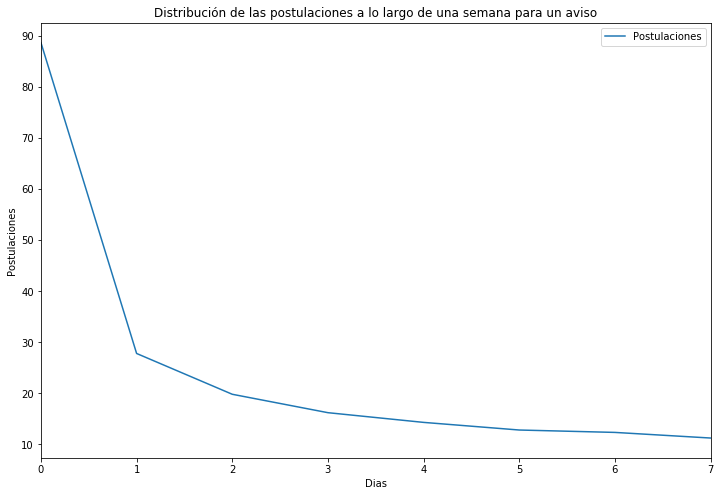

In [32]:
(avisos_semana.loc[avisos_semana['dia'] <= 7, ['dia', 'idpostulante']]\
                .groupby('dia').count()/cant_avisos)\
                .plot(kind='line', figsize=(12, 8))
plt.title('Distribución de las postulaciones a lo largo de una semana para un aviso')
plt.xlabel('Dias')
plt.ylabel('Postulaciones')
plt.legend(["Postulaciones"])

# Volvemos para calcular el top 5 de empresas 

Dado que la curva anterior nos muestra la evolución a lo largo del tiempo para un aviso, no nos importa cuanto dure el aviso para el top, ya que los primeros dias son los esenciales

In [33]:
avisos_semana['inicio'].min()

Timestamp('2018-01-15 00:00:01')

In [34]:
avisos_semana['final'].max()

Timestamp('2018-03-01 04:59:56.142000')

Veamos un top 5 de empresas para el mes las fechas dadas entre 15-01-2018 y 01-03-2018

In [35]:
cant_postulaciones_aviso = avisos_semana.loc[:, ['idaviso', 'idpostulante']].groupby('idaviso').count().reset_index()\
                            .rename(columns={'idpostulante': 'cantidad_postu'})

In [36]:
df_avisos_con_fechaypostu = pd.merge(df_avisos_con_fecha, cant_postulaciones_aviso, on=['idaviso'], how='inner')

In [37]:
top = df_avisos_con_fechaypostu.loc[:, ['denominacion_empresa', 'cantidad_postu', 'idaviso']]\
                                    .groupby('denominacion_empresa')\
                                    .agg({'cantidad_postu': 'mean', 'idaviso': 'count'})

In [38]:
top.head()

,cantidad_postu,idaviso
denominacion_empresa,,
Asistencia Respiratoria Mecánica Domiciliaria,98.000000,1
D.O.T.A.,949.000000,1
123Seguro,1802.333333,3
2way Consulting,16.000000,1
3 empresas,12.000000,1


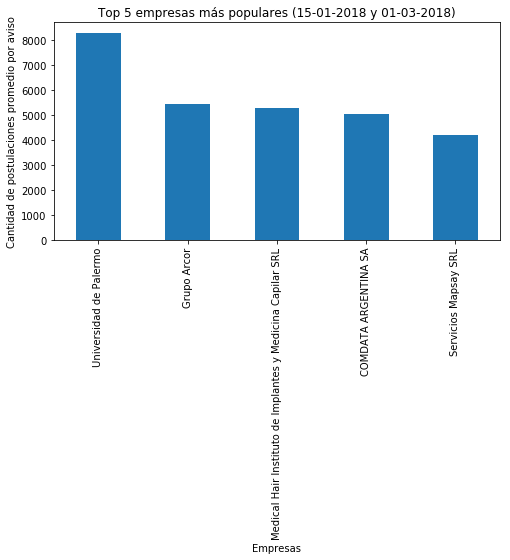

In [39]:
top.sort_values('cantidad_postu', ascending=False).head()['cantidad_postu'].plot(kind='bar', figsize=(8,4))
plt.title('Top 5 empresas más populares (15-01-2018 y 01-03-2018)')
plt.xlabel('Empresas')
plt.ylabel('Cantidad de postulaciones promedio por aviso')

Promedio de avisos por empresa

In [40]:
top['idaviso'].mean()

4.93598233995585

Considerando al menos 5 avisos por empresa

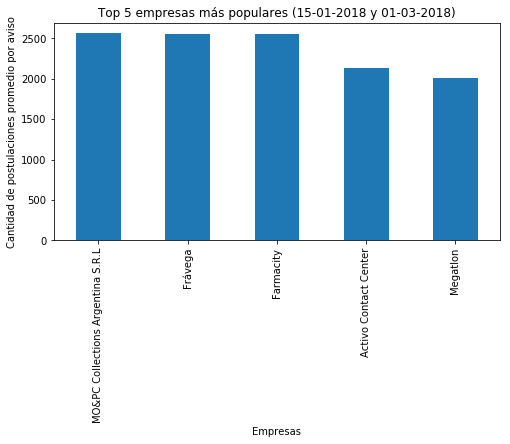

In [41]:
top.loc[top['idaviso']>=5, :].sort_values('cantidad_postu', ascending=False).head()['cantidad_postu'].plot(kind='bar', figsize=(8,4))
plt.title('Top 5 empresas más populares (15-01-2018 y 01-03-2018)')
plt.xlabel('Empresas')
plt.ylabel('Cantidad de postulaciones promedio por aviso')

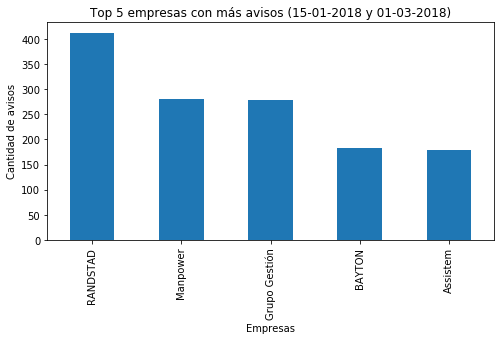

In [42]:
top.sort_values('idaviso', ascending=False).head()['idaviso'].plot(kind='bar', figsize=(8,4))
plt.title('Top 5 empresas con más avisos (15-01-2018 y 01-03-2018)')
plt.xlabel('Empresas')
plt.ylabel('Cantidad de avisos')

# Veo caracteristicas de las empresas y sus relevancias para nuestros datos

In [43]:
def lowercase(row):
    if pd.isnull(row['descripcion']):
        return row['descripcion']   
    
    return row['descripcion'].lower()

In [44]:
df_avisos_con_fechaypostu['descripcion'] = df_avisos_con_fechaypostu.apply(lowercase, axis=1)
df_avisos_detalles['descripcion'] = df_avisos_detalles.apply(lowercase, axis=1)

In [45]:
def extra(row, list_of_words):
    if pd.isnull(row['descripcion']):
        return 0
    for word in list_of_words:
        if word in row['descripcion']:
            return 1
    return 0

In [46]:
pal_claves = {
    'web' : ['web', 'pagina', 'página'],
    'crecimiento' : ['crecim', 'progre'],
    'capacitacion' : ['aprender', 'aprendiza', 'capacitar', 'capacitacion', 'capacitación'],
    'clima laboral' : ['excelente cl', 'clima'],
    'multinacional' : ['multin', 'internacional'],
    'incorp_inmediata' : ['incorporación', 'incorporacion'],
    'disponibilidad_horaria' : ['fines de sem', 'sábado', 'sabado', 'domingo', 'feriado', 'rotativo'],
    'disponibilidad_viajar' : ['viaje', 'viajar'],
    'flexibilidad' : ['flexi'],
    'secundario' : ['secundario compl'],
    'terciario' : ['terciario'],
    'ingles' : ['inglés', 'ingles'],
    'estudiantes' : ['universi', 'estudiant'],
    'conoc_informatica' : ['excel', 'word', 'office'],
    'experiencia' : ['años de exp', 'experiencia'],
    'proactivo' : ['proactiv'],
    'relaciones_pers' : ['relaciones', 'personales']
}

for k, v in pal_claves.items():
    df_avisos_con_fechaypostu[k] = df_avisos_con_fechaypostu.apply((lambda x: extra(x, v)), axis=1)
    df_avisos_detalles[k] = df_avisos_detalles.apply((lambda x: extra(x, v)), axis=1)

Cantidad promedio de postulaciones por aviso

In [47]:
df_avisos_con_fechaypostu['cantidad_postu'].mean()

311.0853822083147

# Cantidad postulaciones promedio según:


# Ofrece capacitación

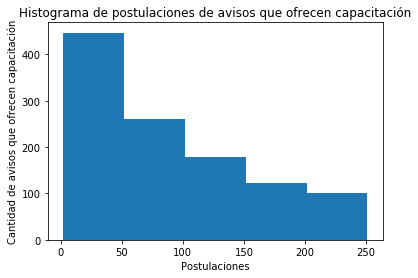

In [48]:
plt.hist(df_avisos_con_fechaypostu.loc[(df_avisos_con_fechaypostu['capacitacion'] == 1)\
                                          &(df_avisos_con_fechaypostu['cantidad_postu'] <= 251)]['cantidad_postu'], bins=5)
plt.xlabel("Postulaciones")
plt.ylabel("Cantidad de avisos que ofrecen capacitación")
plt.title("Histograma de postulaciones de avisos que ofrecen capacitación")
plt.figure(figsize=(17, 1))
plt.show()

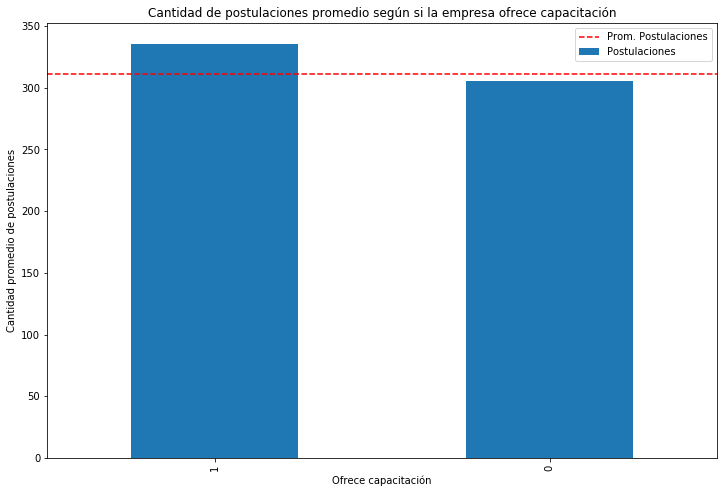

In [49]:
df_avisos_con_fechaypostu.loc[:, ['capacitacion', 'cantidad_postu']].groupby('capacitacion').mean()\
                             .sort_values('cantidad_postu',ascending=False)\
                             .plot(kind='bar', figsize=(12, 8))
        
mean = df_avisos_con_fechaypostu['cantidad_postu'].mean()
plt.axhline(mean, color='red', linestyle='--')
plt.title('Cantidad de postulaciones promedio según si la empresa ofrece capacitación')
plt.xlabel('Ofrece capacitación')
plt.ylabel('Cantidad promedio de postulaciones')
plt.legend(['Prom. Postulaciones', 'Postulaciones'])

# Ofrece buen clima laboral

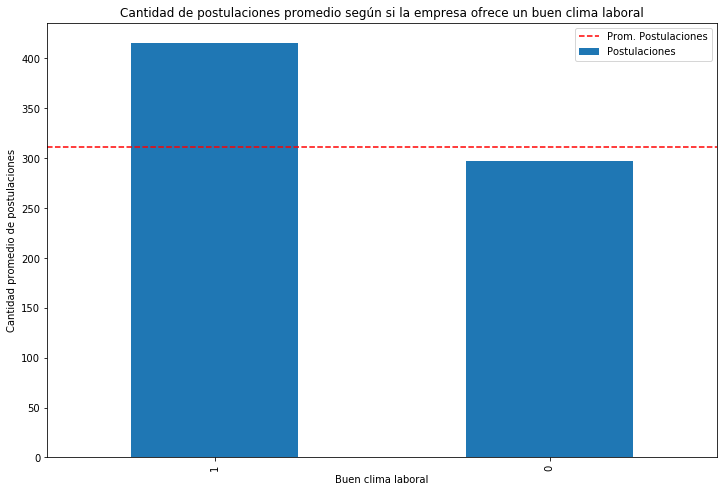

In [50]:
df_avisos_con_fechaypostu.loc[:, ['clima laboral', 'cantidad_postu']].groupby('clima laboral').mean()\
                             .sort_values('cantidad_postu',ascending=False)\
                             .plot(kind='bar', figsize=(12, 8))
        
mean = df_avisos_con_fechaypostu['cantidad_postu'].mean()
plt.axhline(mean, color='red', linestyle='--')
plt.title('Cantidad de postulaciones promedio según si la empresa ofrece un buen clima laboral')
plt.xlabel('Buen clima laboral')
plt.ylabel('Cantidad promedio de postulaciones')
plt.legend(['Prom. Postulaciones', 'Postulaciones'])

# Disponibilidad horaria

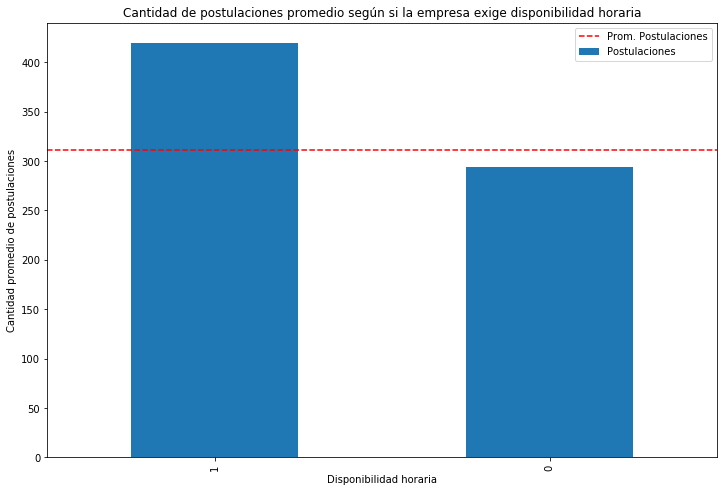

In [51]:
df_avisos_con_fechaypostu.loc[:, ['disponibilidad_horaria', 'cantidad_postu']].groupby('disponibilidad_horaria').mean()\
                             .sort_values('cantidad_postu',ascending=False)\
                             .plot(kind='bar', figsize=(12, 8))
        
mean = df_avisos_con_fechaypostu['cantidad_postu'].mean()
plt.axhline(mean, color='red', linestyle='--')
plt.title('Cantidad de postulaciones promedio según si la empresa exige disponibilidad horaria')
plt.xlabel('Disponibilidad horaria')
plt.ylabel('Cantidad promedio de postulaciones')
plt.legend(['Prom. Postulaciones', 'Postulaciones'])

# Disponibilidad para viajar

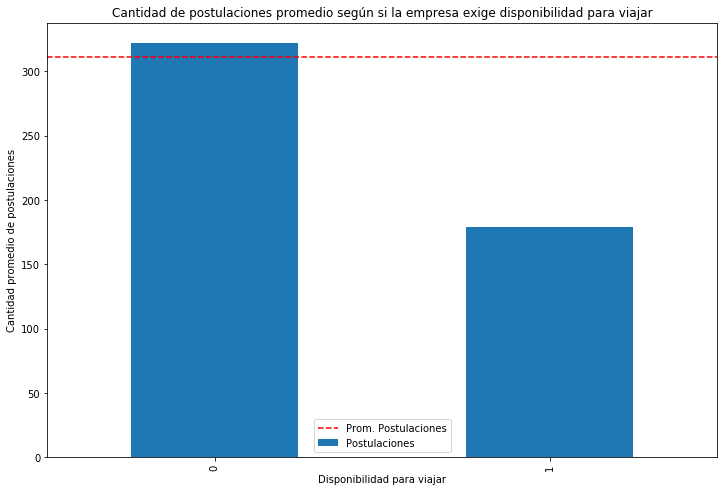

In [52]:
df_avisos_con_fechaypostu.loc[:, ['disponibilidad_viajar', 'cantidad_postu']].groupby('disponibilidad_viajar').mean()\
                             .sort_values('cantidad_postu',ascending=False)\
                             .plot(kind='bar', figsize=(12, 8))
        
mean = df_avisos_con_fechaypostu['cantidad_postu'].mean()
plt.axhline(mean, color='red', linestyle='--')
plt.title('Cantidad de postulaciones promedio según si la empresa exige disponibilidad para viajar')
plt.xlabel('Disponibilidad para viajar')
plt.ylabel('Cantidad promedio de postulaciones')
plt.legend(['Prom. Postulaciones', 'Postulaciones'])

# Piden estudiantes

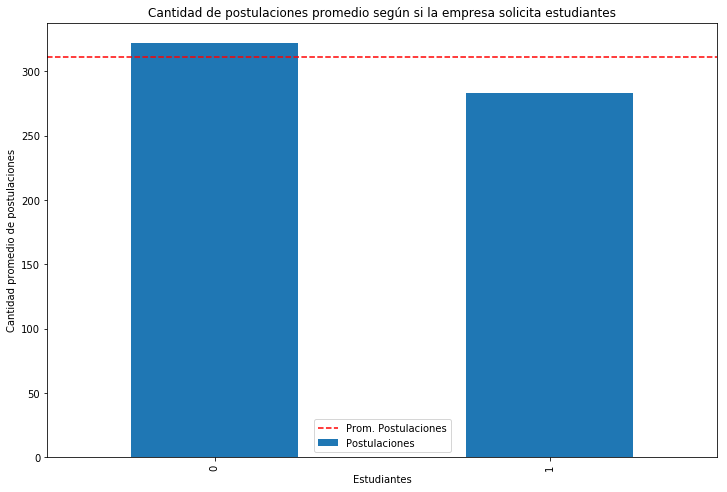

In [53]:
df_avisos_con_fechaypostu.loc[:, ['estudiantes', 'cantidad_postu']].groupby('estudiantes').mean()\
                             .sort_values('cantidad_postu',ascending=False)\
                             .plot(kind='bar', figsize=(12, 8))
        
mean = df_avisos_con_fechaypostu['cantidad_postu'].mean()
plt.axhline(mean, color='red', linestyle='--')
plt.title('Cantidad de postulaciones promedio según si la empresa solicita estudiantes')
plt.xlabel('Estudiantes')
plt.ylabel('Cantidad promedio de postulaciones')
plt.legend(['Prom. Postulaciones', 'Postulaciones'])

# Top 10 factores que solicitan las empresas

In [66]:
def extra_str(row, list_of_words, k):
    if pd.isnull(row['descripcion']):
        return row['factores'];
    for word in list_of_words:
        if word in row['descripcion']:
            return row['factores'] + " - " + k;
    return row['factores'];

In [67]:
df_avisos_con_fechaypostu['factores'] = ""

In [68]:
for k, v in pal_claves.items():
    df_avisos_con_fechaypostu['factores'] = df_avisos_con_fechaypostu.apply((lambda x: extra_str(x, v, k)), axis=1)

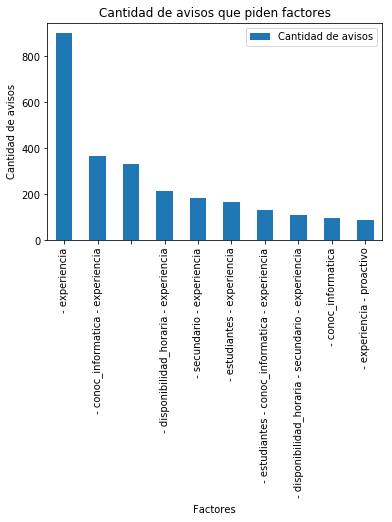

In [132]:
df_avisos_con_fechaypostu.loc[:, ['cantidad_postu', 'factores']].groupby('factores').agg({'cantidad_postu': 'count'})\
                    .sort_values('cantidad_postu', ascending=False).head(10).plot(kind='bar')
    
plt.title('Cantidad de avisos que piden factores')
plt.xlabel('Factores')
plt.ylabel('Cantidad de avisos')
plt.legend(['Cantidad de avisos'])   

Podemos ver que estos factores influyen de manera positiva en la cantidad de postulaciones que tendría un aviso, analicemos más a profundo

# Distribución de postulaciones a un aviso en función del sexo/edad para avisos que piden saber inglés

In [93]:
postu_disp_horaria = pd.merge(\
                    df_avisos_detalles.loc[df_avisos_detalles['ingles']==1, ['idaviso']]\
                    , df_postulaciones, on=['idaviso'], how='inner')

In [94]:
postu_disp_horaria = pd.merge(postu_disp_horaria, df_postulantes_datos, on=['idpostulante'], how='inner')

In [95]:
postu_disp_horaria.head()

,idaviso,idpostulante,fechapostulacion,fechanacimiento,sexo
0,1110640622,EKVNk8,2018-02-25 06:02:11,1965-08-26,MASC
1,1110640622,YBGGJY,2018-02-04 15:12:45,1984-12-11,FEM
2,1112285529,YBGGJY,2018-01-30 11:00:47,1984-12-11,FEM
3,1112295912,YBGGJY,2018-01-30 11:00:30,1984-12-11,FEM
4,1111930643,YBGGJY,2018-01-30 11:05:14,1984-12-11,FEM


In [96]:
postu_disp_horaria.shape

(420887, 5)

Hay muchos que son repetidos, veamos cuantos hay en realidad

In [97]:
postu_disp_horaria['idpostulante'].value_counts().count()

97110

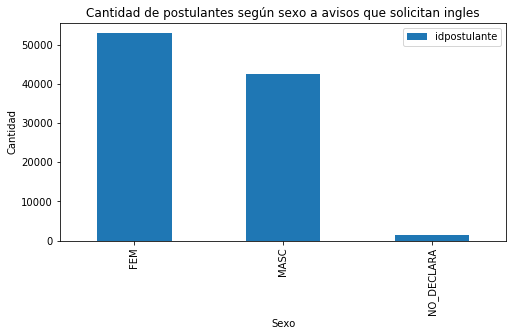

In [98]:
postu_disp_horaria.groupby('sexo').nunique().loc[:, ['idpostulante']].plot(kind='bar', figsize=(8,4))
plt.title('Cantidad de postulantes según sexo a avisos que solicitan ingles')
plt.xlabel('Sexo')
plt.ylabel('Cantidad')

In [99]:
postu_disp_horaria.dropna(subset=['fechanacimiento'], how='any', inplace=True)

In [100]:
postu_disp_horaria["fechanacimiento"] = pd.to_datetime(postu_disp_horaria["fechanacimiento"], errors = 'coerce')

In [101]:
postu_disp_horaria.dropna(subset=['fechanacimiento'], how='any', inplace=True)

In [102]:
def get_edad(row):
    return 2018-row['fechanacimiento'].year

postu_disp_horaria['edad'] = postu_disp_horaria.apply(get_edad, axis=1)

In [103]:
postu_disp_horaria.head()

,idaviso,idpostulante,fechapostulacion,fechanacimiento,sexo,edad
0,1110640622,EKVNk8,2018-02-25 06:02:11,1965-08-26,MASC,53
1,1110640622,YBGGJY,2018-02-04 15:12:45,1984-12-11,FEM,34
2,1112285529,YBGGJY,2018-01-30 11:00:47,1984-12-11,FEM,34
3,1112295912,YBGGJY,2018-01-30 11:00:30,1984-12-11,FEM,34
4,1111930643,YBGGJY,2018-01-30 11:05:14,1984-12-11,FEM,34


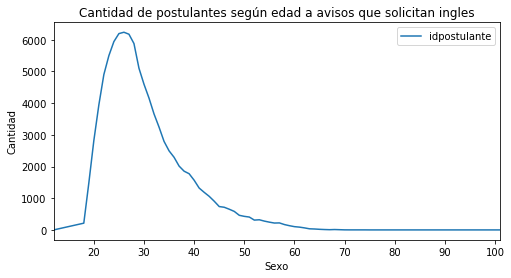

In [104]:
postu_disp_horaria.groupby('edad').nunique().loc[:, ['idpostulante']].plot(kind='line', figsize=(8,4))
plt.title('Cantidad de postulantes según edad a avisos que solicitan ingles')
plt.xlabel('Sexo')
plt.ylabel('Cantidad')